## Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project my goal is to choose a combination of features from a variety of features pertaining to the former employees of Enron. I will then use an algorithm that helps me predict whether this person is a Person of Interest (POI) or not. This is a Supervised Classification problem because we are given the right answer i.e. whether the person is a POI or not. I'm going to try to get as many POIs right as possible. 

The dataset itself consists of email metadata and financial data for about 150 employees of Enron. 
       
In this project I will be engineering the features, pick and tune an algorithm, test and evaluate my identifier. 

# Import Dataset

In [35]:
import sys
import pickle
sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit

### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi"]

### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )


# Outliers. 

First I decide to plot Salary against Bonus and try to see what the scatter plot looks like. Below we can see that there's one observation that is clearly an outlier. Upon further combing through the data, I realize that that must be the observation 'Total'. 

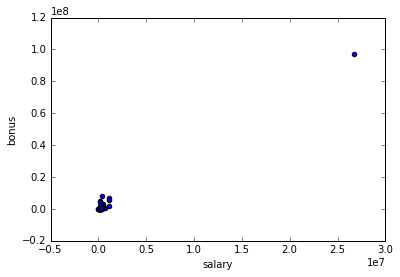

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

I removed the values 'Total and 'The Travel Agency In The Park' and plot Salary vs Bonus again. To me, they didn’t seem to be relevant observations. I also removed all the empty values (Nan’s) from the variable ‘Salary’.

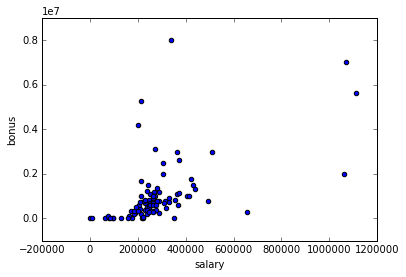

In [37]:
outliers = ["TOTAL", 'The TRAVE AGENCY IN THE PARK']

def remove_outliers(data):
    outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']
    for x in outliers:
        data_dict.pop(x, 0)

    return data
remove_outliers(data_dict)

data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary, bonus)

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()
### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))


# Create New Features

I made two new features and they are both fractions:

* Fraction_from_poi_email: This is a fraction of all the messages a POI sent to this person over all the messages that the POI sent. 

* Fraction_to_poi_email: This is a fraction of all the messages a POI received from this person over all the messages received. 

My hypothesis here was that I thought POIs would send and receive messages to and from other POIs more often than send and receive messages to and from other people in the company and outside of it. 


In [38]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(var1,var2):
    new_list=[]

    for i in data_dict:
        if data_dict[i][var1]=="NaN" or data_dict[i][var2]=="NaN":
            new_list.append(0.)
        elif data_dict[i][var1]>=0:
            new_list.append(float(data_dict[i][var1])/float(data_dict[i][var2]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### Now its time to insert those features in data_dict
counter = 0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"] = fraction_from_poi_email[counter]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[counter]
    counter +=1

#Now I add my two new features to my list of variables. 
    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"] 

### store to my_dataset for easy export below
my_dataset = data_dict

# Algorithm #1

I decide to use Naive Bayes.

In [39]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
##Let's make a separate dataset to use in this decision tree so that we can use my_dataset unchanged 
##later on. 
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

data_nb = featureFormat(my_dataset, features_list)

#Now its time to split the dataset into features and labels. The code below assumes that the 
#first variable is the label.

labels, features = targetFeatureSplit(data_nb)

#Let's split the dataset into training and testing data
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features,labels,test_size=0.1, random_state=42)

#Now let's deploy the naive bayes algorithm and calculate the accuracy of it by using the testing set

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy:', score
print 'Precision:', precision_score(labels_test, pred)  
print 'Recall:', recall_score(labels_test, pred)




Accuracy: 0.266666666667
Precision: 0.181818181818
Recall: 0.5


# Algorithm #2
I then decide to deploy a Decision Tree to compare the results with the Naive Bayes algorithm.  


In [40]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
##Let's make a separate dataset to use in this decision tree so that we can use my_dataset unchanged 
##later on. 
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

data_dt = featureFormat(my_dataset, features_list)

#Now its time to split the dataset into features and labels. The code below assumes that the 
#first variable is the label.

labels, features = targetFeatureSplit(data_dt)

#Let's split the dataset into training and testing data
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features,labels,test_size=0.1, random_state=42)

#Now let's deploy the decision tree and calculate the accuracy of it by using the testing set

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy:', score
print 'Precision:', precision_score(labels_test, pred)  
print 'Recall:', recall_score(labels_test, pred)

importances = clf.feature_importances_



import pandas as pd

data_imp = pd.DataFrame(
    {'Features': features_list[1:], 
     'Importances': importances})
data_imp



Accuracy: 0.6
Precision: 0.25
Recall: 0.25


,Features,Importances
0,salary,0.000000
1,bonus,0.000000
2,fraction_from_poi_email,0.072180
3,fraction_to_poi_email,0.149133
4,deferral_payments,0.000000
5,total_payments,0.000000
6,loan_advances,0.000000
7,restricted_stock_deferred,0.000000
8,deferred_income,0.000000
9,total_stock_value,0.148962


# Choosing The Algorithm

I decide to go with the Decision Tree instead of Naive Bayes because the Accuracy and Precision for Decision Tree is higher than Nive Bayes. Recall is a little lower than Naive Bayes but I can tune the algorithm to be able to achieve a higher Recall. 

# Feature Selection

The three features that I end up using are ‘fraction_to_poi_email’, ‘expenses’, and ‘shared_receipt_with_poi’. I tried a combination of features to see which combination of features would give me the highest precision and recall possible in the decision tree I deploy. 

I did not have to do any scaling because I was using  a Decision Tree and Decision Trees don’t require scaling usually. 

Feature Importances for the Variables I used: 

| Features                | Importances|   
|-------------------------|------------|
| fraction_to_poi_email   | 0.232919   |   
| expenses                | 0.063768   | 
| shared_receipt_with_poi | 0.255057   |  

In [41]:
##According to these results I pick the following features. 
features_list_rev = ['poi', 'fraction_to_poi_email',
                     'expenses', 'shared_receipt_with_poi']
##Now I deply the decision tree again for the new features. 
data_dt_rev = featureFormat(data_dict, features_list_rev)

#Now its time to split the dataset into features and labels. The code below assumes that the first variable is the 
#label.

labels, features = targetFeatureSplit(data_dt_rev)

#Let's split the dataset into training and testing data
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features, labels, test_size=0.1, random_state=42)


#Now let's deploy the decision tree and calculate the accuracy, precision and recall before 
#tuning the algorithm


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy, Precision and Recall before tuning the algorithm:'
print 'Accuracy:', score
from sklearn.metrics import precision_score, recall_score
print 'Precision:', precision_score(labels_test, pred)  
print 'Recall:', recall_score(labels_test, pred)




Accuracy, Precision and Recall before tuning the algorithm:
Accuracy: 0.75
Precision: 0.5
Recall: 0.666666666667


# Tuning An Algorithm

Algorithms have parameters and tuning an algorithm means specifying those parameters instead of using the default values. When you tune an algorithm appropriately, you can customize it to your dataset and increase accuracy, recall and precision. If you don’t tune an algorithm then your model will not be optimized for your dataset. 

We have already deployed the algorithm without tuning it. Now let's deploy the decision tree and calculate the accuracy, precision and recall after tuning it. A min_samples_split = 6 or higher gives the best precision and recall.

As we can see, the accuracy jumps to 91% and we can see an increase in precision and recall as well after we tune the algorithm. 

I have used the parameter min_samples_split, which is the minimum number of samples required to split an internal node.

In [42]:
clf = DecisionTreeClassifier(min_samples_split = 2)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy, Precision and Recall after tuning the algorithm with min_samples_split = 2:'
print 'Accuracy:', score
print 'Precision:', precision_score(labels_test, pred)  
print 'Recall:', recall_score(labels_test, pred)

clf = DecisionTreeClassifier(min_samples_split = 6)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy, Precision and Recall after tuning the algorithm with min_samples_split = 6:'
print 'Accuracy:', score
print 'Precision:', precision_score(labels_test, pred)  
print 'Recall:', recall_score(labels_test, pred)

clf = DecisionTreeClassifier(min_samples_split = 11)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy, Precision and Recall after tuning the algorithm with min_samples_split = 11:'
print 'Accuracy:', score
print 'Precision:', precision_score(labels_test, pred)  
print 'Recall:', recall_score(labels_test, pred)

Accuracy, Precision and Recall after tuning the algorithm with min_samples_split = 2:
Accuracy: 0.75
Precision: 0.5
Recall: 0.666666666667
Accuracy, Precision and Recall after tuning the algorithm with min_samples_split = 6:
Accuracy: 0.916666666667
Precision: 1.0
Recall: 0.666666666667
Accuracy, Precision and Recall after tuning the algorithm with min_samples_split = 11:
Accuracy: 0.916666666667
Precision: 1.0
Recall: 0.666666666667


# Validation Of The Model

Validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. 


# Evaluation Metrics 

In this project, I have used Accuracy, Precision and Recall to validate my models. 

When you build a model for a classification problem you almost always want to look at the accuracy of that model as the number of correct predictions from all predictions made. This is the classification accuracy.

In this project, our main goal is to identify POIs so False Negatives i.e. not recognizing someone as a POI when someone is actually a POI is more harmful than False Positives i.e. recognizing someone as a POI when someone is actually not a POI. 

Hence, while accuracy is important it can also be misleading because even with a high accuracy, the number of False Negatives that the model can predict can be high. We need a high Recall along with Accuracy. 

Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. A low Recall value indicates many False Negatives. 

In our model, we have a Recall of 0.67 which tells us that 67% of the time the model is correct in flagging the POIs whereas 33% of the time it identifies employers as POIs when they are not POIs. 

We can see an improvement in Recall after tuning the algorithm. 

#### Dump your classifier, dataset and features list so that anyone can run it and check your result. 

In [43]:
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )


# Conclusion
In this project, since we are trying to identify the Person of Interest(POI), we can say that according to the decision tree algorithm, we can say that 100% of the time that our algorithm identified a POI it really was a POI because our precision is 0.1 and 0% of the time if it flagged a person as POI, then it was a false alarm. 

Recall tells us that our algorithm is 67% of the time correct in flagging the POI while the other 33% of the time it was showing us a false negative which means that it would not recognize a person as a POI while he/she actually was. 

While our numbers seem to be reasonable, there is obviously room for improvement. We can keep looking into the text of the data and see if we can garner any more information from there. 

# References:

https://en.wikipedia.org/wiki/Cross-validation_(statistics)
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=sklearn+naive+bayes
http://stackoverflow.com/questions/11277432/how-to-remove-a-key-from-a-python-dictionary
http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/